In [2]:
import pickle
import numpy as np

features_min, features_max = np.load("norm_constants.npy",allow_pickle=True).tolist()

with open('cluster_year.pkl', 'rb') as f:
    cluster_year = pickle.load(f)

with open('name_encoder.pkl', 'rb') as f:
    le = pickle.load(f)


# ARIMA

In [4]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.utils.dependencies import _check_soft_dependencies
import warnings
from sktime.forecasting.arima import AutoARIMA
from sklearn.metrics import mean_squared_error
import pandas as pd

warnings.filterwarnings("ignore") 

years2concat = {}
for c, y in cluster_year:
    if c not in years2concat:
         years2concat[c] = []    
    years2concat[c].append(y)


y_pred = []
y_true = []

for c, y in cluster_year:
    for j,k in cluster_year[c,y][1]:
        targs = cluster_year[c,y][1][j,k][1]
        datas = cluster_year[c,y][1][j,k][0][:,0]
        datas2 = cluster_year[c,y][1][j,k][0][:,2]

        ys = pd.Series(targs[:4].flatten())
        y_ = pd.Series(targs.flatten())
        xst = pd.DataFrame(datas2[:4].reshape(-1,1),index=ys.index)    


        xs = pd.DataFrame(datas2.reshape(-1,1),index=y_.index)  
        #print(xs)

        amodel = AutoARIMA(suppress_warnings=True,start_p=2,start_q=2,seasonal=False,maxiter=500).fit(ys,X=xst)

        y_p = amodel.predict(fh=np.asarray([1]),X=xs)
       
        y_pred.append(float(y_p)) #, batch_size=batch_size)
        #print(targs,y_pred[len(y_pred) - 1])

        y_true.append(targs[4])
        #break



In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(np.asarray(y_pred).flatten(),np.asarray(y_true).flatten())    
print("r2: ",r2)

mae = mean_absolute_error(np.asarray(y_pred).flatten() * features_max[0],np.asarray(y_true).flatten() * features_max[0])
print("mae: ",mae)

mse = mean_squared_error(np.asarray(y_pred).flatten() * features_max[0],np.asarray(y_true).flatten() * features_max[0])
print("mse: ",mse)

r2:  0.7195369929114069
mae:  184639931.85786268
mse:  2.1436493467374224e+17


# residuals

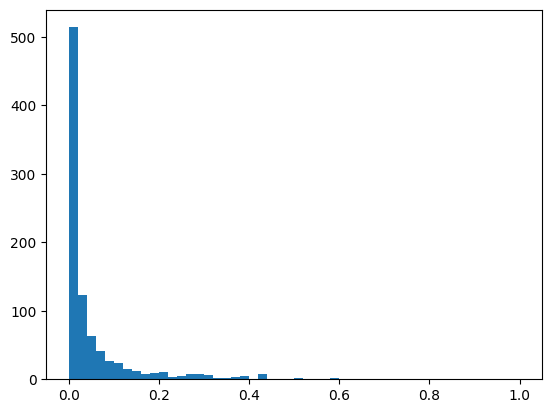

In [15]:
import matplotlib.pyplot as plt
import numpy as np

r = np.asarray(y_true) - np.asarray(y_pred)
# Create the histogram
plt.hist(y_true, bins=50)

# Show the plot
plt.show()

In [ ]:
from scipy.stats import kstest

max_pval = 0.
max_a = 0
max_b = 0

y_true = np.asarray(y_true)

for a in np.arange(0.1,3,0.1):
    for b in np.arange(1,100,0.01):
        stat, p_val = kstest(y_true[(y_true > 0) & (y_true < 1)],'beta',args=(a,b))
        #print(a,b,p_val)
        if p_val > max_pval:
            max_pval = p_val
            max_a = a
            max_b = b

In [ ]:
max_pval

In [ ]:
max_a

In [ ]:
max_b

In [40]:
kstest(y_true[(y_true > 0) & (y_true < 1)],'beta',args=(1,50))

KstestResult(statistic=0.1930118588896047, pvalue=9.582708241550457e-30, statistic_location=0.056927409733032376, statistic_sign=-1)

In [42]:
from scipy.stats import beta
params = beta.fit(y_true[(y_true > 0) & (y_true < 1)], floc=0, fscale=1)

# The first two elements of 'params' are alpha and beta
alpha_estimated = params[0]
beta_estimated = params[1]

print(f"Estimated alpha: {alpha_estimated}")
print(f"Estimated beta: {beta_estimated}")

Estimated alpha: 0.35389210406968014
Estimated beta: 5.238943607335745


In [45]:
kstest(y_true[(y_true > 0) & (y_true < 1)],'beta',args=(0.363,7.5))

KstestResult(statistic=0.05565059009488771, pvalue=0.0074284882740531495, statistic_location=0.0003866076298769371, statistic_sign=-1)